In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ
from qiskit.test.mock import FakeVigo

from analysis.analysis import run_circuits, analyze_results, analyze_results_ignis
from analysis.constants import SIMULATOR
from analysis.error_correction import CustomErrorCorrection, IgnisErrorCorrection
from models.circuits import SinglePlaquette
from models.constants import Groups

In [2]:
IBMQ.load_account()
PROVIDER = IBMQ.get_provider(hub='ibm-q-research', group='hu-berlin-1', project='main')
PROVIDER.backends()
BACKEND_HARDWARE = FakeVigo()
BACKEND_SIMULATOR = PROVIDER.get_backend(SIMULATOR)

In [3]:
z2_plaquette = SinglePlaquette(n_qubits=5)
z2_plaquette = z2_plaquette.generate_circuit(q_control=1)
z2_plaquette.draw()

/home/miguel/Documents/WORK/Research/plaquette-models/venv/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


┌───┐   ┌───┐┌─────┐                                                     »
q_0: ┤ H ├─■─┤ S ├┤ SDG ├─────────────────────────────────────────────────────»
     ├───┤ │ ├───┤└─────┘┌───┐    ┌───┐     ┌───┐  ┌───┐ ┌───────┐┌───┐┌─────┐»
q_1: ┤ H ├─■─┤ S ├───■───┤ S ├─■──┤ S ├──■──┤ S ├──┤ H ├─┤ U1(2) ├┤ H ├┤ SDG ├»
     ├───┤   └───┘   │   ├───┤ │ ┌┴───┴┐ │  └───┘  └───┘ └───────┘└───┘└─────┘»
q_2: ┤ H ├───────────■───┤ S ├─┼─┤ SDG ├─┼────────────────────────────────────»
     ├───┤               └───┘ │ └┬───┬┘ │ ┌─────┐                            »
q_3: ┤ H ├─────────────────────■──┤ S ├──┼─┤ SDG ├────────────────────────────»
     ├───┤                        └───┘  │ └┬───┬┘┌─────┐                     »
q_4: ┤ H ├───────────────────────────────■──┤ S ├─┤ SDG ├─────────────────────»
     └───┘                                  └───┘ └─────┘                     »
c: 5/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                      ┌───┐ ░ ┌─┐            
«q_0: ───────────────────────────────■─┤ H ├─░─┤M├────────────
«        ┌─────┐   ┌─────┐   ┌─────┐ │ ├───┤ ░ └╥┘┌─┐         
«q_1: ─■─┤ SDG ├─■─┤ SDG ├─■─┤ SDG ├─■─┤ H ├─░──╫─┤M├─────────
«      │ └─────┘ │ └─────┘ │ └┬───┬┘   └───┘ ░  ║ └╥┘┌─┐      
«q_2: ─┼─────────┼─────────■──┤ H ├──────────░──╫──╫─┤M├──────
«      │         │  ┌───┐     └───┘          ░  ║  ║ └╥┘┌─┐   
«q_3: ─┼─────────■──┤ H ├────────────────────░──╫──╫──╫─┤M├───
«      │  ┌───┐     └───┘                    ░  ║  ║  ║ └╥┘┌─┐
«q_4: ─■──┤ H ├──────────────────────────────░──╫──╫──╫──╫─┤M├
«         └───┘                              ░  ║  ║  ║  ║ └╥┘
«c: 5/══════════════════════════════════════════╩══╩══╩══╩══╩═
«                                               0  1  2  3  4

In [3]:
time_vector = np.arange(1, 2, 0.2)
hpc_res, circuits = run_circuits(number_links=4, backend=BACKEND_HARDWARE, time_vector=time_vector)
hpc_res_sim, circuits_sim = run_circuits(number_links=4, backend=BACKEND_SIMULATOR, time_vector=time_vector)

/home/miguel/Documents/WORK/Research/plaquette-models/venv/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


In [5]:
natural_count_sim, _ = analyze_results(number_links=4, result_hpc=hpc_res_sim, time_vector=time_vector,
                                       circuits=circuits_sim)

In [6]:
error_correction = CustomErrorCorrection(n_qubits=5, shots=1000)
error_correction = error_correction.build_probability_matrix(backend=BACKEND_HARDWARE)

natural_count, corrected_count = analyze_results(number_links=4, result_hpc=hpc_res, time_vector=time_vector,
                                                 circuits=circuits, output_correction=error_correction)

In [11]:
ignis_err_corr = IgnisErrorCorrection(n_qubits=5, shots=1000)
meas_filter = ignis_err_corr.get_meas_fitter(backend=BACKEND_HARDWARE)
_, corrected_count_ignis = analyze_results_ignis(number_links=4, result_hpc=hpc_res, time_vector=time_vector,
                                                 circuits=circuits, result_key='11111',
                                                 meas_filter=meas_filter)

In [ ]:
plt.plot(time_vector, natural_count_sim, label='simulator')
plt.plot(time_vector, corrected_count, label='corrected custom')
plt.plot(time_vector, corrected_count, label='corrected ignis')
plt.plot(time_vector, natural_count, label='natural')
plt.legend()



In [3]:
model_to_run = {
    'plaquette': SinglePlaquette,
    'gauge_group': Groups.U1,
}

hpc_res_sim, circuits_sim = run_circuits(3, 1.0, np.arange(1, 2, 0.2), backend=BACKEND_SIMULATOR, model=model_to_run)

/home/miguel/Documents/WORK/Research/plaquette-models/venv/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


In [4]:
natural_count_sim, _ = analyze_results(number_links=3, result_hpc=hpc_res_sim, time_vector=list(np.arange(1, 2, 0.2)),
                                       circuits=circuits_sim)

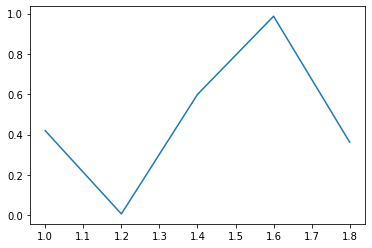

In [5]:
plt.plot(np.arange(1, 2, 0.2), natural_count_sim)